# All in One for the Exam

Time flies, and the exam is coming. To help you to review the course, we have prepared this notebook, which contains all the materials we have covered in the course. We hope this notebook can help you to review the course and prepare for the exam.

This exam review document __does not cover the materials you studed from the lecture, whereas 
it only covers the materials from tutorial and lab__. You should also review the lecture materials.

Here is the list of topics we have covered and will be covered in the exam:

1. introduction to data.table
2. using data.table to manipulate data
3. basic data visualization
4. introduction to linear regression
5. introduction to logistic regression

## 1. Introduction to data.table

Broadly speaking, there are two kinds of data: __structured data__ and __unstructured data__. 
Structured data is data that has a structure, such as a table, whereas unstructured data is data that does not have a structure, such as a text file. In this course, we focus on structured data. This means all the data we will use look like tables, such 
as the following one:

![data.table-example](../drawio/R-data-table-illustration.png)

> Small story (will not be tested in the exam): I had a talk with a person who is the principal data scientist and  working for the government. He told me that the government is implementing a strategy called "AI in 2030". The goal of this strategy is to make the government to be more data-driven and AI-driven. He told me that every year they have to pay a lot of money to consultancies such as Boston Consulting Group (BCG) to do data analysis for them. He said that the government now is planning to combine data scientist and ChatGPT to do the data analysis. They are hoping that they could reduce 40% of the cost by doing so. The idea is that they will only hire BCG for those very complex data analysis tasks. For those simple tasks, they will use AI to do the data analysis. The main tool that BCG uses is Excel, SQL and Tableau. They are all table-based tools. This means having a good understanding of table-based data analysis is very important. This is why we start from data.table.

The basic syntax of data.table is summarized in the following illustration. __You will
not be tested on the syntax of data.table in the exam__. However, you will be tested on the
underlying concepts of data.table, such as the type of variables (integer, character, factor, etc.).
In the future if you will be working as a data scientist, you can use data.table to do big
data analysis. You will need to know the syntax of data.table for practical use not for the exam.

![data.table-syntax](../drawio/R-data-table-illustration2.png)

## 2. Using data.table to manipulate data

Now, we will use data.table to do some data analysis. We will use the `Community Innovation Survey` (CIS)
to do the analysis. The CIS is a survey that is conducted by the European Union (EU) to collect data
about innovation activities of firms. The survey we will use is the 2021 CIS from Germany.

In [ ]:
# install packages
install.packages("stargazer")
# install ISLR if you don't have it
# install.packages("ISLR")
install.packages("corrplot")

In [2]:
# library for data analysis
library(data.table)
library(magrittr)
library(ggplot2)
library(knitr)
library(stargazer)
library(MASS)
library(ISLR)
library(corrplot)

In [ ]:
# read data
cis <- fread("https://raw.githubusercontent.com/oceanumeric/data-science-go-small/main/data/innovation_survey/extmidp21.csv")

In [ ]:
# check dimension, which shows 5083 rows and 284 columns
dim(cis)

In [ ]:
# take a look at the first 5 rows
head(cis)

From the above table, we can see that we have:

- integer variables: `id`
- character variables: `branche`, `ost`, etc.
- numeric variables (dbl): `bges`, `bges18`, etc.

In [ ]:
# now we want to select all variables that are type of dbl (double - numeric like 3.1415926)
# .SD means subset of data in j (select all columns)
# .SDcols means subset columns that are double which is by = is.double
# all things we will do in excel, SQL, or data.table can be summarized as
# I want to do things on rows (i) or columns (j) by some conditions (by)
# here we want to select all columns that are double
cis %>%
    # using [i, j, by] grammar
    .[, .SD, .SDcols = is.double] %>% head()

Before we continue, let's get to know the meaning of some variables (we have 41 numeric variables in total, so we will not cover all of them):

- bges: number of employees (average from 2018 to 2020)
- bges18: number of employees in 2018
- um18: sales in 2018
- lp19: labor productivity in 2019
- softws19: software application intensity in 2019
- wbp:  Weiterbildungskostenanteil (share of training costs)
- invs:  Investitionsintensitaet (investment intensity)

From the above table, you can see that we have many `NA` values. This is because the survey is a voluntary survey. This means that firms can choose whether they want to participate in the survey or not. If they choose to participate in the survey, they can choose whether they want to answer all the questions or not. This is why we have many `NA` values - missing values.

This is very common in real-world data. To deal with this issue, we normally do the following (will not be tested in the exam):

- check the number of missing values
- check the pattern of missing values
- decide whether we want to drop the missing values or impute the missing values

In [ ]:
# check the number of missing values in each column
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    head(10)

#### Missing Values

- wmenup: Umsatzanteil der Weltmarktneuheiten in 2020 (share of world market novelties in 2020)
- lap2022:  Entw. Innovationsaufw. 2022 in % (Development of innovation expenditure 2022 in %)
- fueoefms:  Intensitaet öffentliche FuE-Förderung (Intensity of public R&D funding)

We do not know exactly why we have so many missing values. However, we can guess that the reason is that the firms do not want to disclose the information or do not have information. For instance, because of the pandemic in 2020,
many firms might not have the information about the share of world market novelties in 2020. 
This could be the reason why we have so many missing values for `wmenup`.

We have shown that the sample size is 5083, if one variable has more than 50% missing values, we will drop this variable.
This is because we can do nothing about this variable. If we impute the missing values, we will introduce bias to the data.

In [ ]:
dim(cis)

In [ ]:
# get variable names that have more than 50% missing values
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    head()
# notice that the variable name of second column is a `.`
# we will rename it as `num_missing` (number of missing values)

In [ ]:
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    # rename the second column
    setnames(., old = ".", new = "num_missing") %>%
    head()

In [ ]:
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    # rename the second column
    setnames(., old = ".", new = "num_missing") %>%
    # add missing percentage column
    # nrow is the number of rows in the dataset nrow(cis) = dim(cis)[1] = 5083
    .[, missing_rate := num_missing / nrow(cis)] %>%
    head()

> Normally, I will use `%>%` to do everything in one block. However, here I am trying to show you the steps one by one. So, you can see the process clearly.

In [ ]:
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    # rename the second column
    setnames(., old = ".", new = "num_missing") %>%
    # add missing percentage column
    # nrow is the number of rows in the dataset nrow(cis) = dim(cis)[1] = 5083
    .[, missing_rate := num_missing / nrow(cis)] %>%
    # filter variables that have missing rate > 0.5
    # we are using [i, j, by] grammar again on rows now
    .[missing_rate >= 0.5]

# as you can see we have 18 variables that have missing rate > 0.5
# we will remove them from the dataset

In [ ]:
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    # rename the second column
    setnames(., old = ".", new = "num_missing") %>%
    # add missing percentage column
    # nrow is the number of rows in the dataset nrow(cis) = dim(cis)[1] = 5083
    .[, missing_rate := num_missing / nrow(cis)] %>%
    # filter variables that have missing rate > 0.5
    # we are using [i, j, by] grammar again on rows now
    .[missing_rate >= 0.5] %>%
    # select the first column as they are the variable names
    # [i, j, by]
    .[, rn]

In [ ]:
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    # rename the second column
    setnames(., old = ".", new = "num_missing") %>%
    # add missing percentage column
    # nrow is the number of rows in the dataset nrow(cis) = dim(cis)[1] = 5083
    .[, missing_rate := num_missing / nrow(cis)] %>%
    # filter variables that have missing rate > 0.5
    # we are using [i, j, by] grammar again on rows now
    .[missing_rate >= 0.5] %>%
    # select the first column as they are the variable names
    # [i, j, by]
    # save the variable names to a variable called vars_to_remove
    .[, rn] -> vars_to_remove

In [ ]:
# in jupyter notebook we can use vars_to_remove to see the variable names
vars_to_remove

In [ ]:
# or you can print out the variable names
print(vars_to_remove)

In [ ]:
# now we will remove the variables from the dataset
cis %>%
    # select variables that are numeric (double)
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    # with means we are usig column names instead of column indices
    # at by position
    .[, !vars_to_remove, with = FALSE] %>%
    head()

In [ ]:
# compare with the original dataset
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    dim()  # 41 columns (variables)

In [ ]:
cis %>%
    # select variables that are numeric (double)
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    # with means we are using column names instead of column indices
    # with means we are using column names instead of column indices
    .[, !vars_to_remove, with = FALSE] %>%
    dim()  # 23 columns (variables)

In [ ]:
# with all numeric variables and not many missing values
# we can check the correlation between variables
cis %>%
    # select variables that are numeric (double)
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    # with means we are using column names instead of column indices
    # with means we are using column names instead of column indices
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix
    corrplot(method = "color")

You might see the correlation plot like the above one in the exam. I will tell you
the meaning of variables:

- bges: number of employees (average from 2018 to 2020)
- bges18: number of employees in 2018
- um18: sales in 2018
- lp19: labor productivity in 2019
- softws19: software application intensity in 2019
- wbp:  Weiterbildungskostenanteil (share of training costs)
- invs:  Investitionsintensitaet (investment intensity)
- exs:  Exportintensitaet insgesamt (total export intensity)
- markets:  Marketingaufwendungen Intensitaet (marketing expenditure intensity)
- designs:  Designaufwendungen Intensitaet (design expenditure intensity)

For instance, I might ask you:

- in the graph, we see the correlated cluster of `markets`, `designs`, and `softws19`. What does this mean?
- in the graph, we see that there is correlation between `exs`, `bges` and `bges18`, what kind of hypothesis can we make based on this correlation?

In [ ]:
# we can also use circlize to plot the correlation matrix
cis %>%
    # select variables that are numeric (double)
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    # with means we are using column names instead of column indices
    # with means we are using column names instead of column indices
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper")

The correlation plot could give us a big picture on what's going on. For instance,

- factors are grouped together based on their correlation
- the bigger the circle, the higher the correlation
- the color of the circle indicates the sign of the correlation (blue: positive, red: negative)

Based on the correlation plot, you can combine your domain knowledge to make hypothesis.

However, __This kind of correlation plot only gives a global picture. It does not tell us the whole story__. For instance, we are not zooming into the industry level analysis. __It is 
very likely that the correlationb between say `markets` and `designs` is different for different industries__. This is why we need to do industry level analysis.

### CIS with Industry Level Analysis

Now, we will do industry level analysis. We will use the `branche` variable to do the
industry level analysis.

- `branche`:  Einteil. in 21 Wirtschaftszweige (classification into 21 economic sectors)

In [ ]:
# get to know branche
cis %>%
    # select branche with [i, j, by]
    # .(branchen) is the same as c("branchen")
    .[, .(branche)] %>%
    head()

In [ ]:
# we can check how many unique values in branche
cis %>%
    .[, .(branche)] %>%
    # unique() returns the unique values
    unique()  # 21 unique values (industries)

In [ ]:
# branche is character
# we can calculate the frequency of each branche
cis %>%
    .[, .(branche)] %>%
    # calculate the frequency of each branche
    # [i, j, by] by = branche means we are grouping by branche
    # .N is calculating the number of rows in each group
    .[, .N, by = branche]

In [ ]:
cis %>%
    .[, .(branche)] %>%
    # calculate the frequency of each branche
    # [i, j, by] by = branche means we are grouping by branche
    # .N is calculating the number of rows in each group
    .[, .N, by = branche] %>%
    # sort the frequency in descending order
    # order(-N) means we are sorting N in descending order
    # we put it into i position because we are sorting rows
    .[order(-N)]

The industry distribution shows the 'big picutre' of German economy. We can see that the most important industry is `Transport/Post` , `Wasser/Entsorgung/Recycling`, and `Metallerzeugung/-bearbeitung`. __Be careful that we might have selection bias here__. This is because the survey is a voluntary survey. This means that firms can choose whether they want to participate in the survey or not. So, the industry distribution might not be representative.

When we see those industries, we are interested in:

- what are the characteristics of those industries?
- which industries are similar to each other?
- which industries are different from each other?
- what are the characteristics of the firms in those industries?

Since we have many industries, to find out which industries are similar to each other 
is not easy by analyzing the dataset. __We have to reply on our domain knowledge__. Here,
we expect that `Transport/Post` and `Metallerzeugung/-bearbeitung` are similar to each other.

With our domain knowledge, we will focus on three groups of industries:

- indus1: `Transport/Post`, `Metallerzeugung/-bearbeitung`, and `Maschinenbau`
- indus2: `Unternehmensdienste`,  `Unternehmensberatung/Werbung`, and `Finanzdienstleistungen`
- indus3: `Elektroindustrie`, and `Mediendienstleistungen`, and `EDV/Telekommunikation`

We will now select the firms in those industries and group them together.

In [ ]:
# create a variables that will include industries we will focus on
indus1 <- c(
    "Transport/Post", "Metallerzeugung/-bearbeitung", "Maschinenbau"
)
indus2 <- c(
    "Unternehmensdienste", "Unternehmensberatung/Werbung", "Finanzdienstleistungen"
)
indus3 <- c(
    "Elektroindustrie", "Mediendienstleistungen", "EDV/Telekommunikation"
)

In [ ]:
# now select all the rows that have branche in indus1, indus2, indus3
cis %>%
    # [i, j, by] at i postion
    # filter out branche are in indus1, indus2, indus3
    # | means or in R
    # %in% means is in
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    dim()

In [ ]:
cis %>%
    # [i, j, by] at i postion
    # filter out branche are in indus1, indus2, indus3
    # | means or in R
    # %in% means is in
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # verify the result
    .[, .(branche)] %>%
    unique()

In [ ]:
cis %>%
    # [i, j, by] at i postion
    # filter out branche are in indus1, indus2, indus3
    # | means or in R
    # %in% means is in
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # verify the result
    .[, .(branche)] %>%
    # calculate the frequency of each branche
    .[, .N, by = branche]

In [ ]:
# now we group them 
cis %>%
    # [i, j, by] at i postion
    # filter out branche are in indus1, indus2, indus3
    # | means or in R
    # %in% means is in
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    # fill indus1, indus2, indus3 based on branche
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    head()  # variable industry is added to the dataset at the last column

In [ ]:
cis %>%
    # [i, j, by] at i postion
    # filter out branche are in indus1, indus2, indus3
    # | means or in R
    # %in% means is in
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    # fill indus1, indus2, indus3 based on branche
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # verify the result by selecting branche and industry
    .[, .(branche, industry)] %>%
    head()

After classifying the industry, we can compare the correlation between different
industries. We want to see whether the relationship between for instance `export` and 
`labor productivity` is different for different industries.

In [ ]:
# we will create a vector that will include all the variables we will use

In [ ]:
# plot correlation matrix for indus1 - machineary industry or related (transport/post, metal, machine)
cis %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # filter out the indust1
    .[industry == "indus1"] %>%
    # select the variables are double
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper")

In [ ]:
# plot correlation matrix for indus2 - business services industry or related (business services, consulting, finance)
cis %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # filter out the indust1
    .[industry == "indus2"] %>%
    # select the variables are double
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper")

In [ ]:
# plot correlation matrix for indus3 - IT industry or related (IT, telecom, media)
cis %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # filter out the indust1
    .[industry == "indus3"] %>%
    # select the variables are double
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper")

Now, let's put them together and compare them. I will write a function to do this because 
we do not have to repeat the same code again and again (it will __not__ be tested in the exam).

In [ ]:
plot_correlation <- function(industry_name) {
    cis %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # filter out the indust1
    .[industry == industry_name] %>%
    # select the variables are double
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper", title=industry_name, mar=c(0,0,2,0))
}

In [ ]:
# let's put them together and compare
cis %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # select the variables are double
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper")  -> corr_overall

In [ ]:
# figure size
options(repr.plot.width = 10, repr.plot.height = 10)
plot_correlation("indus1")
plot_correlation("indus2")
plot_correlation("indus3")

Now, I put everything together and highlight some interesting phenomena.

![corr-plot](./indus_corr.png)

As you can see that the correlations between `export` and other variables are very different
cross different industries.

__Summary:__ for this part, you need to know that industry level analysis is very important.
For the coding part, you will not be tested in the exam. However, you need to know how to
do it in real life.

## 3. Basic data visualization

In this section, we will learn how to use basic data visualization tools to 
conduct exploratory data analysis by focusing on the following topics:

- univariate analysis (histogram, boxplot, density plot)
- bivariate analysis (scatter plot, line plot, bar plot)

Many concepts in this section will be tested in the exam. So, please pay attention to this section.

In [3]:
# we will use two datasets
# community innovation survey (cis), religion and innovation survey (ris)
# read data again
cis <- fread("https://raw.githubusercontent.com/oceanumeric/data-science-go-small/main/data/innovation_survey/extmidp21.csv")

In [ ]:
str(cis)

As you can see that we have many variables. It is not easy to understand the data by looking at the numbers. So, we need to visualize the data. We will select some variables of interest:

- ias:            Innovationsintensitaet
- iasx:             Stutzung Innovationsintensitaet
- iainvs:            Intensitaet investive Inno.
- iainvsx:          Stutzung Intens.inv.Inno
- iafues:           Intensitaet interne FuE
- iafuesx:         Stutzung Intens. interne FuE
- iavfues:         Intensitaet externe FuE
- iavfuesx:        Stutzung Intens. externe FuE
- iasos:           Intensitaet sonst. Innovationsaufw
- iasosx:          Stutzung sonst. Innovationsaufw

All those variables are related to innovation, which could be used as dependent variables.

In [ ]:
# get column index of ias
which(colnames(cis) == "ias")
# get column index of iasosx
which(colnames(cis) == "iasosx")

In [ ]:
# now we will select the columns we need from 107 to 116
cis %>%
    # in [i, j, by] you can use index too instead of column name
    .[, 107:116] %>%
    head()

In [ ]:
cis %>%
    .[, 107:116] %>%
    # check number of missing values
    sapply(function(x) sum(is.na(x))) %>%
    as.data.table(keep.rownames = TRUE)

As you can see that there are so many missing values. We will drop those missing values.
We will filter the data based on `ias`.

In [ ]:
# we will have 2056 firms, which is fine for our analysis
cis %>%
    .[!is.na(ias)] %>%
    dim()

In [ ]:
# we will focus on firms that have innovation intensity score
cis %>%
    # remove missing values for ias 
    .[!is.na(ias)] %>%
    # check the distribution of industry
    .[, .N, by = branche]

In [5]:
# create a variables that will include industries we will focus on
indus1 <- c(
    "Transport/Post", "Metallerzeugung/-bearbeitung", "Maschinenbau"
)
indus2 <- c(
    "Unternehmensdienste", "Unternehmensberatung/Werbung", "Finanzdienstleistungen"
)
indus3 <- c(
    "Elektroindustrie", "Mediendienstleistungen", "EDV/Telekommunikation"
)

In [ ]:
# we will filter out those three industries we will focus on
cis %>%
    # remove missing values for ias 
    .[!is.na(ias)] %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "machineary",  # call indus1 as machineary
        ifelse(branche %in% indus2, "business", "IT")
    )] %>%
    head()

In [ ]:
# check distribution of industry
cis %>%
    # remove missing values for ias 
    .[!is.na(ias)] %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "machineary",  # call indus1 as machineary
        ifelse(branche %in% indus2, "business", "IT")
    )]%>%
    .[, .N, by = industry]  # quite balanced

The above process is about cleaning and organizing the dataset, which is very important.
Now, we will create a new dataset based on our clearning process and call it `cis2`.

In [6]:
cis %>%
    # remove missing values for ias 
    .[!is.na(ias)] %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "machineary",  # call indus1 as machineary
        ifelse(branche %in% indus2, "business", "IT")
    )] -> cis2

In [ ]:
dim(cis2)  # we only have 1042 firms 

In [ ]:
# let's check innovation intensity score (ias)
cis2 %>%
    .[, .(ias)] %>% head()

In [ ]:
# get summary statistics of ias
cis2 %>%
    .[, .(ias)] %>%
    summary()

The above summary is very important. It tells us that the first quartile is 0. This means that
25% of the firms do not have any innovation. The median is 0.001, which means that 50% of the firms have innovation intensity less than 0.001. The third quartile is 0.037, which means that 75% of the firms have innovation intensity less than 0.037. The maximum is 1.156, which means that the maximum innovation intensity is 1.156.

This is __very common__ in business world as most of the firms are not very innovative.

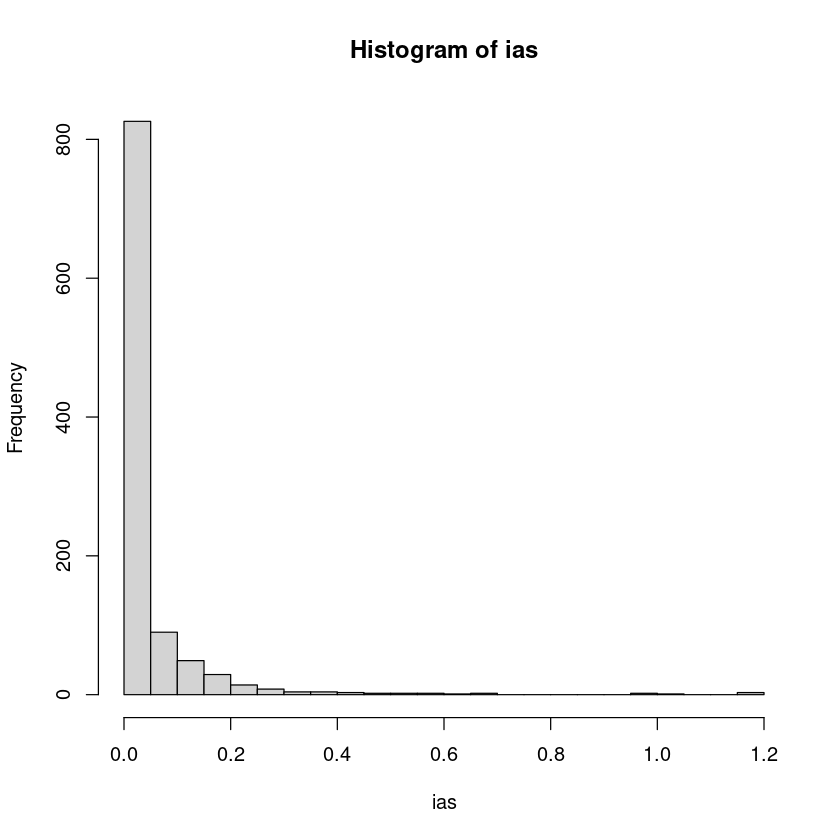

In [7]:
# plot the distribution of ias as it is a continuous variable
cis2 %>%
    .[, .(ias)] %>%
    with(hist(ias, breaks = 20))

In [8]:
# focus on firms that have ias > 0
cis2 %>%
    .[ias > 0] %>%
    dim()  # we have 536 firms

[1] 536 285

In [9]:
# check balance of industry
cis2 %>%
    .[ias > 0] %>%
    .[, .N, by = industry]  # not very balanced

industry,N
<chr>,<int>
IT,246
machineary,192
business,98


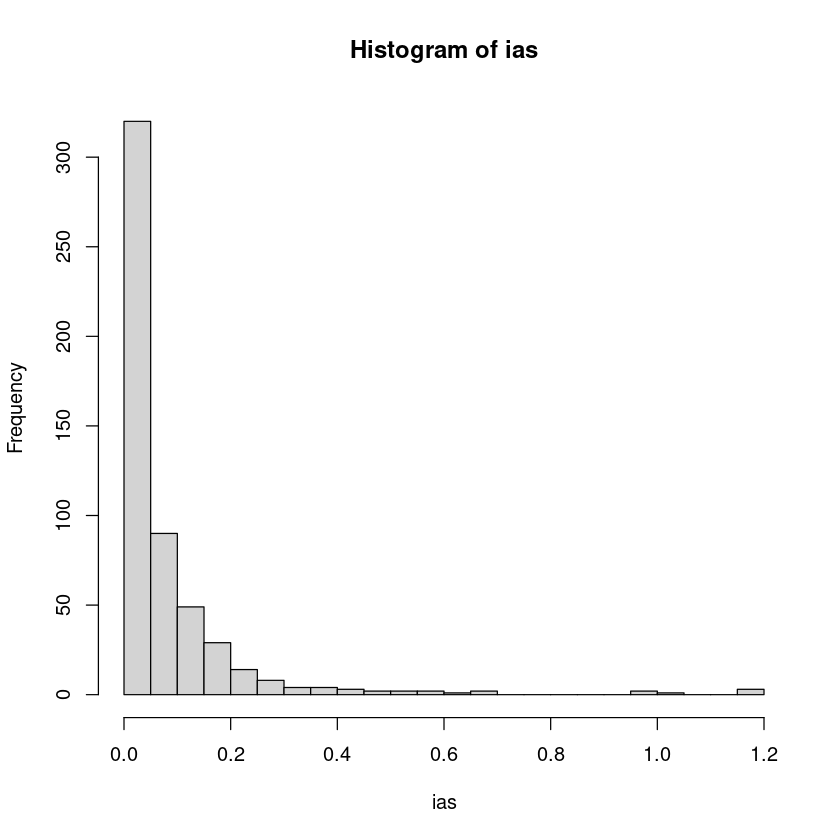

In [10]:
# focus on firms that have ias > 0
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias)] %>%
    with(hist(ias, breaks = 20))

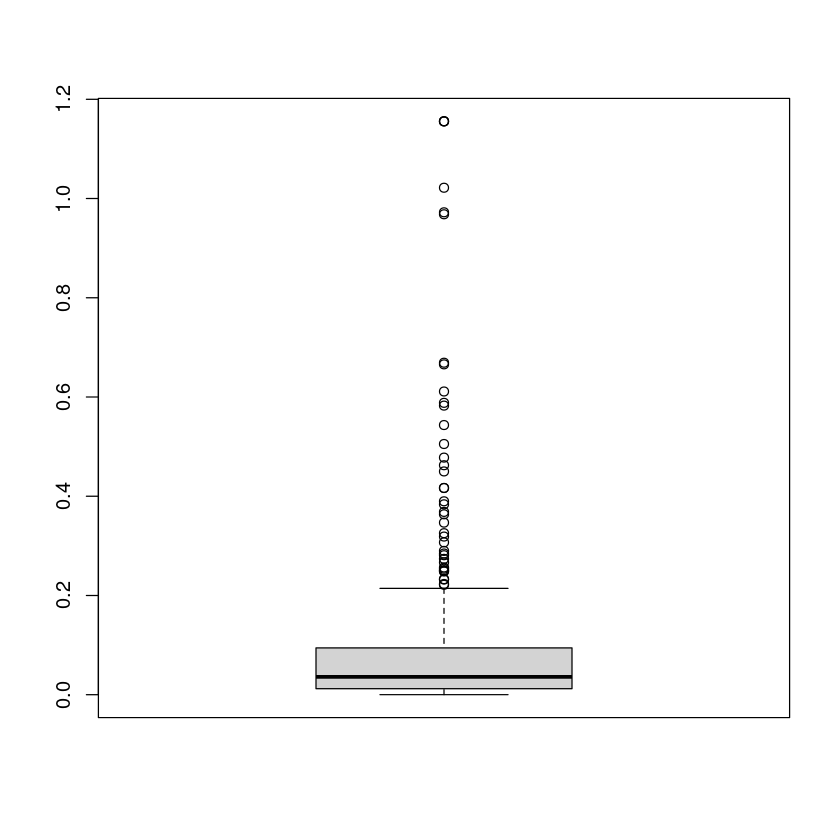

In [11]:
# boxplot
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias)] %>%
    with(boxplot(ias))

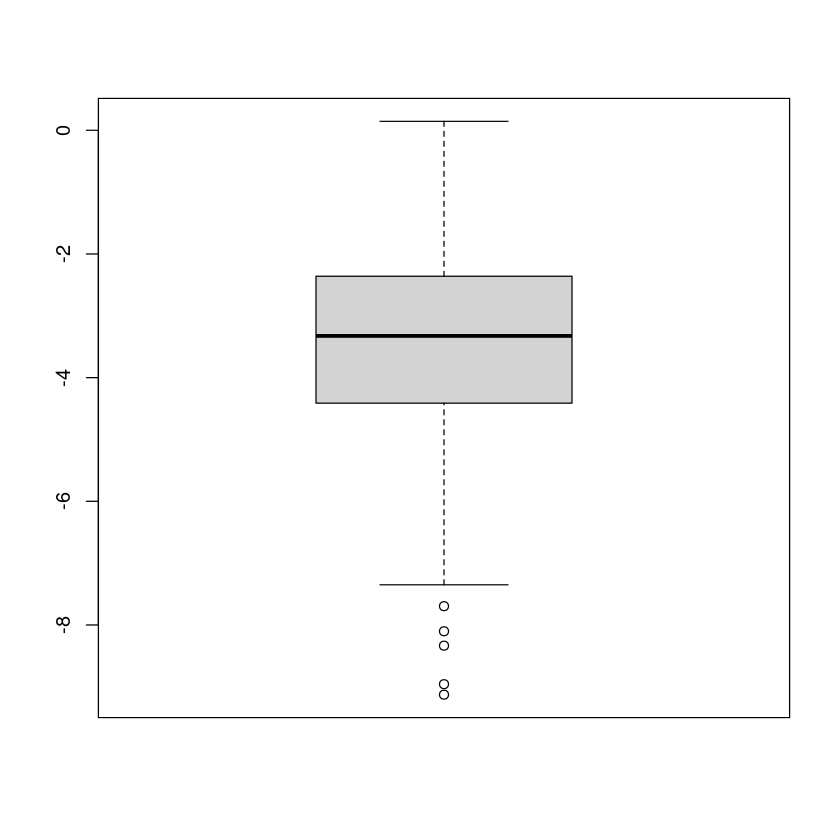

In [12]:
# as it can be seen, there are some outliers
# the distribution is right skewed
# we will use log transformation to make it more normal
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias)] %>%
    # log transformation
    with(boxplot(log(ias)))


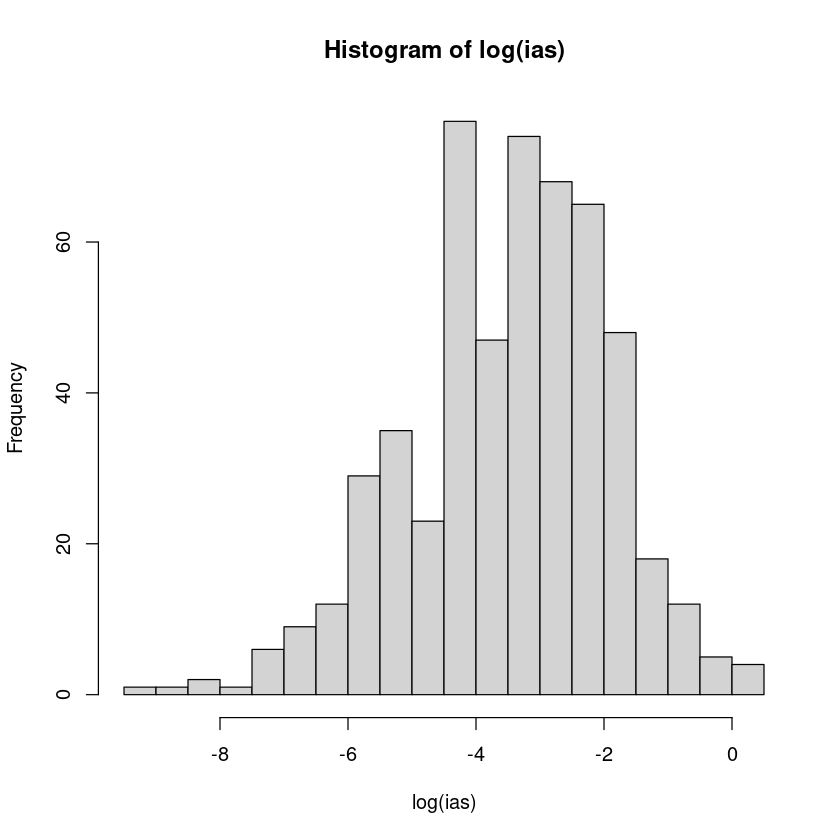

In [13]:
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias)] %>%
    # log transformation and histogram
    with(hist(log(ias), breaks = 20))

### Normal Distribution

When we fit a linear regression model, if dependent variable is __continuous__, we prefer
the dependent variable to be normally distributed. So, we need to check whether the dependent variable is normally distributed. If not, we could use some transformation to make it normally distributed.
As we have covered in the lecture, there are __two main distributions__ you need to know:

- normal distribution (Gaussian distribution)
- binomial distribution

Possion distribution will not be tested in the exam.

![normal](../images/binomial-to-poisson2.png)

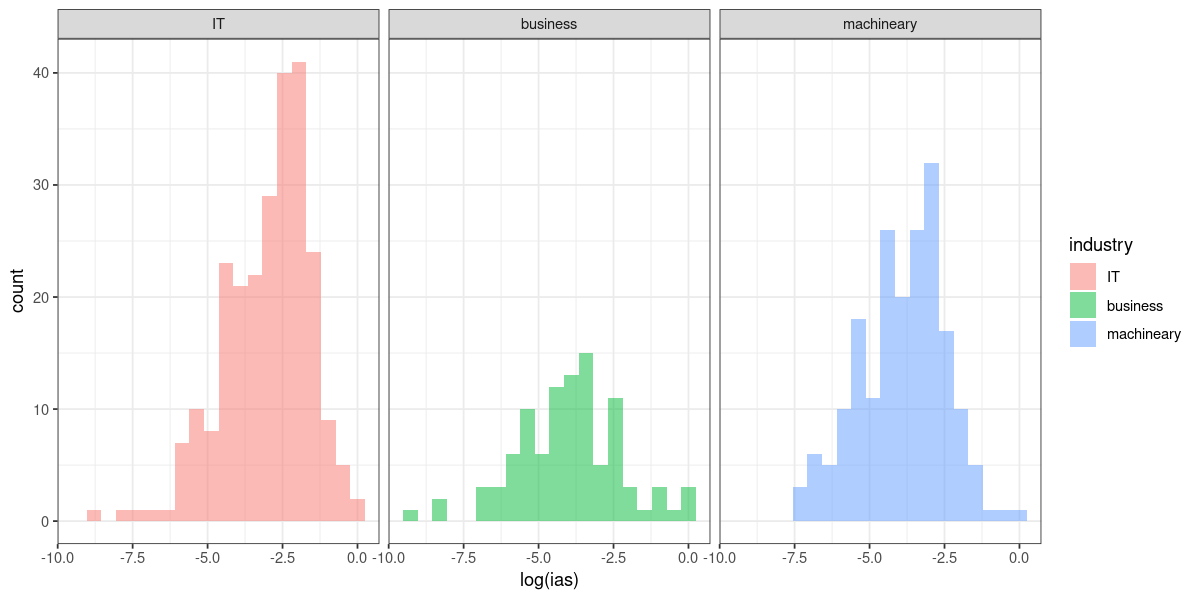

In [14]:
# we now want to check whether log(ias) is distributed similarly across industries
# here we will use ggplot2
options(repr.plot.width = 10, repr.plot.height = 5)
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias, industry)] %>%
    ggplot(aes(x = log(ias), fill = industry)) +
    geom_histogram(bins = 20, alpha = 0.5) +
    facet_wrap(~industry, nrow = 1) +
    theme_bw()

For all industries, the shape is of bell shape. This means that they are more or less normally distributed after we:

- filter out the innovation intensity > 0
- take the log of innovation intensity

### From univariate to bivariate analysis

We now have a basic understanding of the distribution of innovation intensity. Now, we want to see how innovation intensity is related to other variables. We will focus on the following variables:

- bges: average number of employees (firm size)
- um:  Umsatz in Mio. Euro (turnover in million euro)
- exs: Exportquote (export ratio)
- lp: Laborproduktivitaet (labor productivity)
- invs: Investitionsquote (investment ratio)
- markets:  Marketingaufwendungen Intensitaet (marketing intensity)
- designs: Designaufwendungen Intensitaet (design intensity)
- softws: Softwareaufwendungen Intensitaet (software intensity)
- wbp: Weiterbildungskostenanteil (training intensity)
- fues:  Intensitaet FuE (R&D intensity)
- iainvs: Intensitaet investive Inno. (investment innovation intensity)

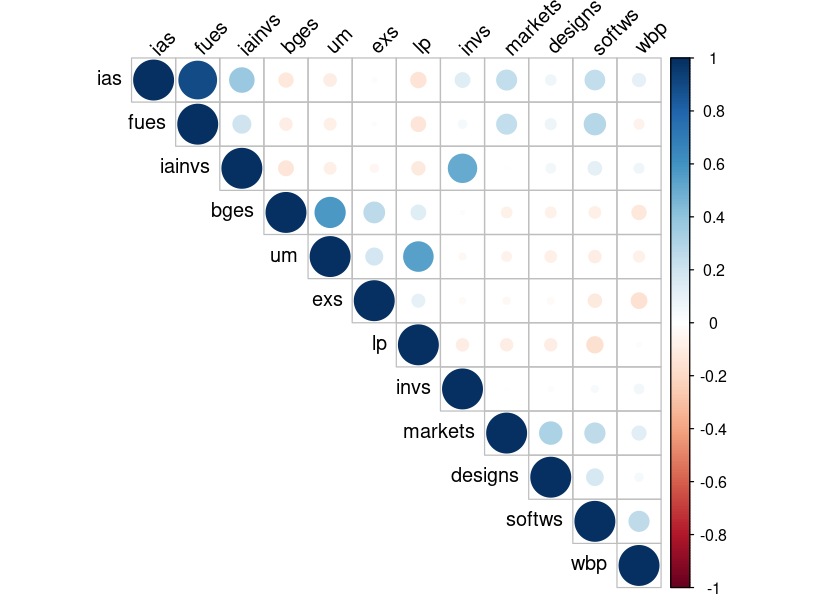

In [32]:
# check correlation between ias and other variables
cis2 %>%
    # only select firms that have ias > 0
    .[ias > 0] %>%
    # select variables we need
    .[, .(ias, fues, iainvs, bges, um, exs, lp, invs, markets, designs, softws, wbp)] %>%
    # check correlation without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot correlation matrix
    corrplot(method="circle", type="upper", tl.col="black", tl.srt=45)



As we can see that `ias` (innovation intensity) and `fues` (R&D intensity) are highly correlated. This is not surprising because R&D is the main source of innovation.


It is interesting that the correlation between `ias` and `lp` is very low and even
negative. This means that the more innovative firms are not necessarily more productive.
However, to be more accurate, we need to do a regression analysis.

In [16]:
# now we plot the scatter plot of ias and other variables
cis2 %>%
    .[, .(ias, markets)] %>%
    head()

ias,markets
<dbl>,<dbl>
0.120000000,NA
0.020220373,0.002829295
0.142699580,0.017154280
0.020420665,0.001565584
0.058788523,NA
0.005916505,0.001795862


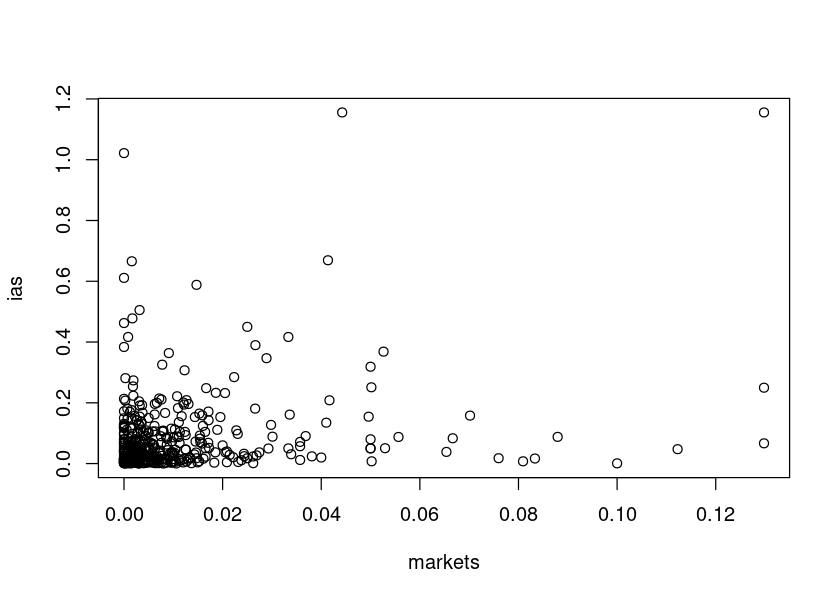

In [22]:
options(repr.plot.width = 7, repr.plot.height = 5)
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias, markets)] %>%
    with(plot(markets, ias))

Overall, you can see that there is a positive relationship between `ias` and `markets`,
however, the relationship is not very strong.

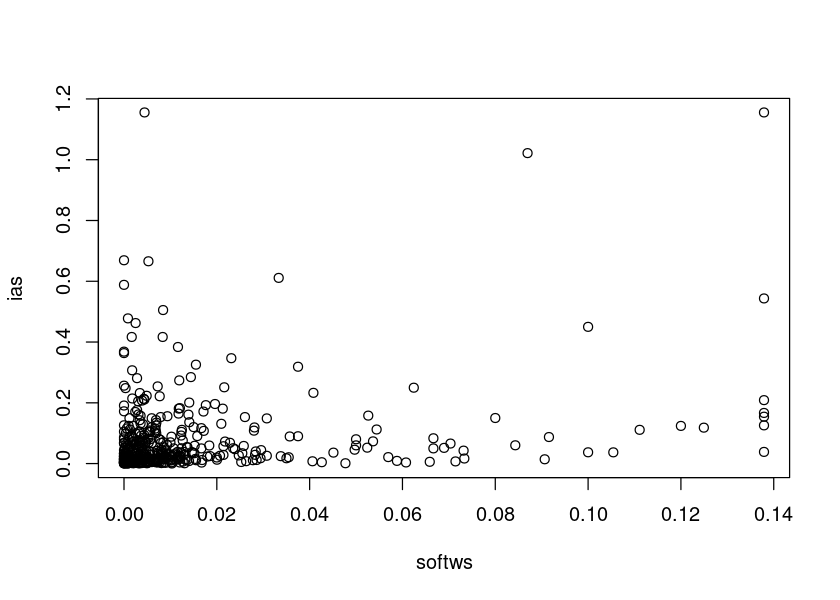

In [23]:
# ias and softws
options(repr.plot.width = 7, repr.plot.height = 5)
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias, softws)] %>%
    with(plot(softws, ias))

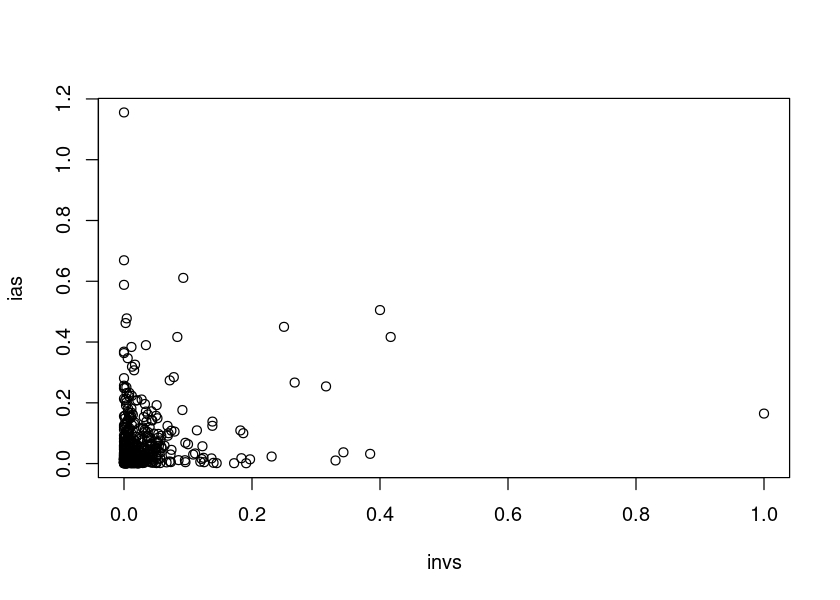

In [38]:
options(repr.plot.width = 7, repr.plot.height = 5)
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias, invs)] %>%
    with(plot(invs, ias))

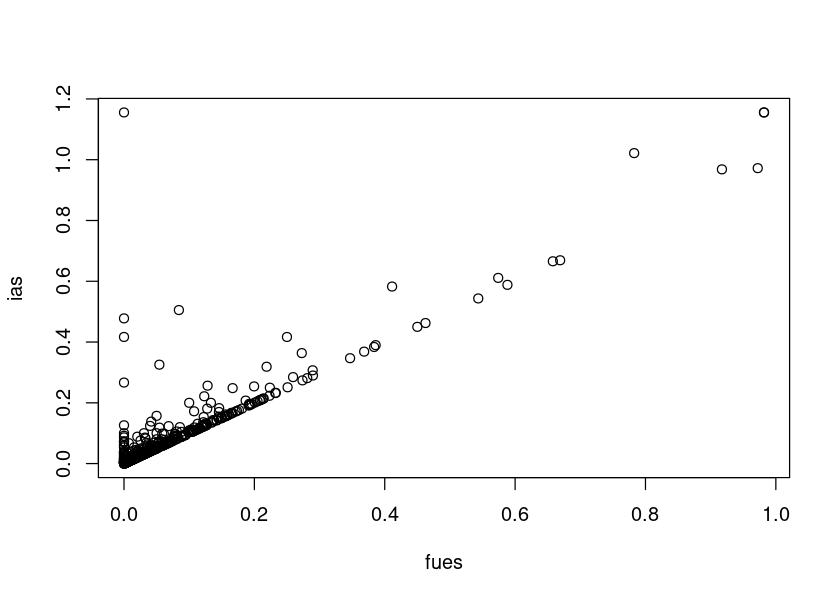

In [33]:
options(repr.plot.width = 7, repr.plot.height = 5)
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias, fues)] %>%
    with(plot(fues, ias)) 

`fues` means R&D intensity. As you can see that there is a positive relationship between
`ias` and `fues`. The above graph shows those two factors are almost identical.

## 4. Introduction to regression analysis 

Many exam questions will be related to regression analysis. So, please pay attention to this section.
Before we run a regression analysis, let's first understand the basic concepts of regression analysis
via simulation.

We know that the relationship between `weight` and `height` is roughly linear and positive.
We will use this relationship to simulate the data. When we simulate the data, we will add some
random nosie to the data as there is no perfect linear relationship between `weight` and `height`.
To make you understand the concept, I will simulate the data step by step.

- scenario 1: no noise (perfect linear relationship)
- scenario 2: add some noise (not perfect linear relationship)
- scenario 3: add some outliers (not perfect linear relationship)

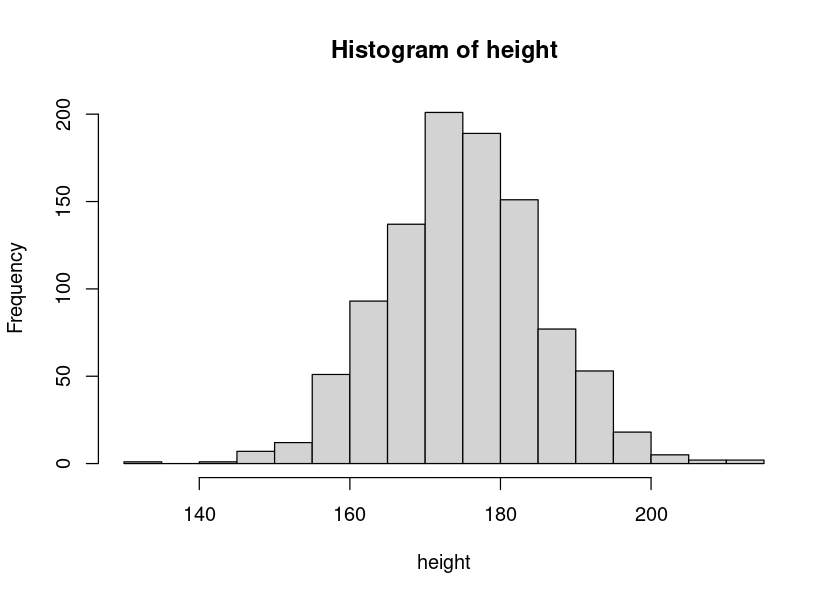

In [56]:
# simulate weight and height
# generate 1000 random numbers from normal distribution
# mean =  175cm and sd = 10cm
height <- rnorm(1000, mean = 175, sd = 10)
# plot histogram
hist(height, breaks = 20)

Now, we have the weight, we assume that there is a linear relationship between `height` and `weight`,
which has the following form:

$$
weight = \beta_0 + \beta_1 \times height
$$

Here we set $\beta_0 = 55$ and $\beta_1 = 0.1$. This means that if the height increases by 1 cm, the weight will increase by 0.1 kg.

$$
weight = 50 + 0.1 \times height
$$

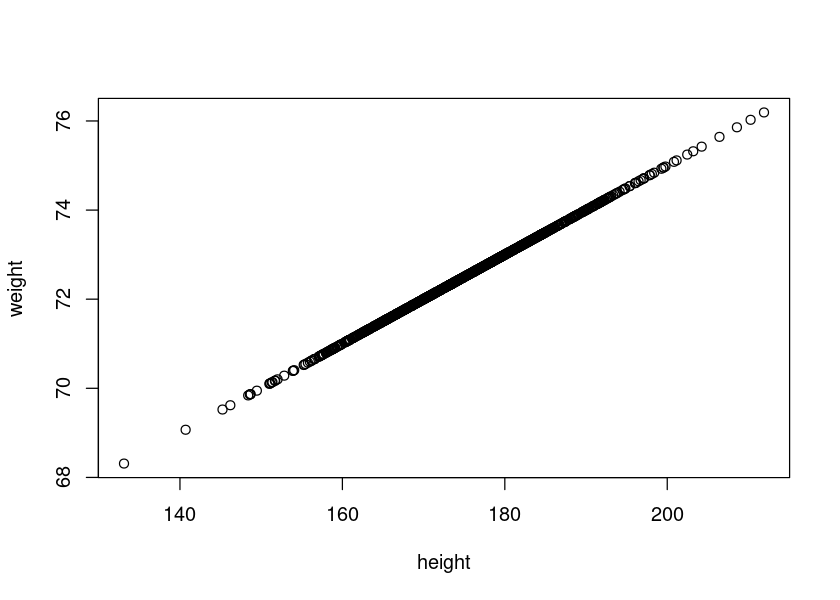

In [60]:
# generate weight
weight <- 55 + 0.1 * height

# plot scatter plot
plot(height, weight)

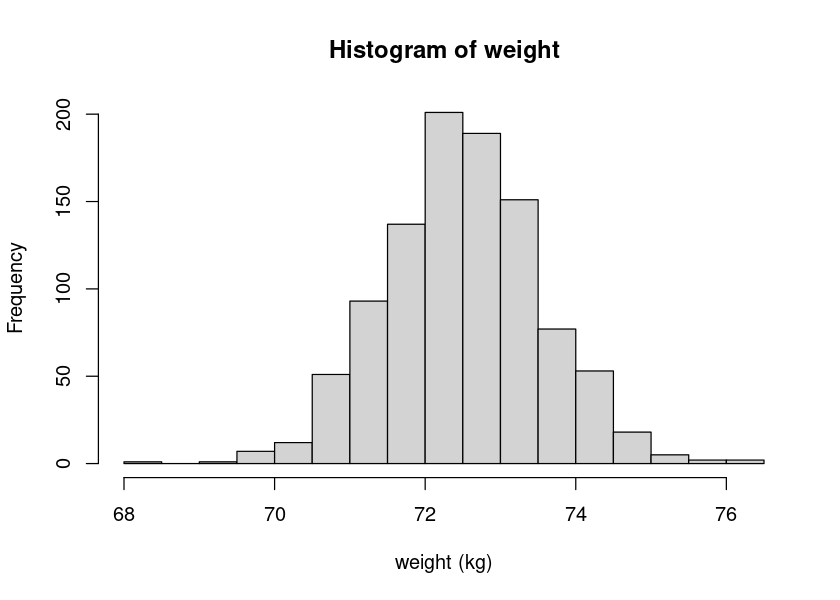

In [62]:
# plot histogram of weight
hist(weight, breaks = 20, xlab="weight (kg)")

In [63]:
# now let's fit a linear regression model
sm1 <- lm(weight ~ height)

stargazer(sm1, type = "text")


                                        Dependent variable:                     
                    ------------------------------------------------------------
                                               weight                           
--------------------------------------------------------------------------------
height                                        0.100***                          
                                              (0.000)                           
                                                                                
Constant                                     55.000***                          
                                              (0.000)                           
                                                                                
--------------------------------------------------------------------------------
Observations                                   1,000                            
R2                         

### Regression Analysis with CIS data

Now, we will learn how to use regression analysis to analyze the relationship between
innovation intensity and other variables. Here we are setting up a simple linear regression
meaning:

- dependent variable: innovation intensity (`ias`)
- independent variable: marketing intensity (`markets`), `softws`, `designs`, `wbp`, `fues`, `inv`
, etc. 


Let's start from the simplest model: `ias` and `invs`, our hypothesis is that __there is a
positive relationship between investment and innovation intensity__. We will use `lm` function to do the regression analysis.
If we write down the regression equation, it will be:

$$
ias = \beta_0 + \beta_1 invs + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

Here we assume that the error term is normally distributed with mean 0 and variance $\sigma^2$.


In [36]:
# simple regression 
model1 <- lm(ias ~ invs, data = cis2)

# check summary
summary(model1)


Call:
lm(formula = ias ~ invs, data = cis2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.11102 -0.03781 -0.03643  0.00083  1.11829 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.037262   0.003421  10.892   <2e-16 ***
invs        0.073755   0.036212   2.037    0.042 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.08951 on 788 degrees of freedom
  (252 observations deleted due to missingness)
Multiple R-squared:  0.005237,	Adjusted R-squared:  0.003974 
F-statistic: 4.148 on 1 and 788 DF,  p-value: 0.04201


In [37]:
# print out coefficients
stargazer(model1, type = "text")


                        Dependent variable:    
                    ---------------------------
                                ias            
-----------------------------------------------
invs                          0.074**          
                              (0.036)          
                                               
Constant                     0.037***          
                              (0.003)          
                                               
-----------------------------------------------
Observations                    790            
R2                             0.005           
Adjusted R2                    0.004           
Residual Std. Error      0.090 (df = 788)      
F Statistic            4.148** (df = 1; 788)   
Note:               *p<0.1; **p<0.05; ***p<0.01


Based on the above regression result, we can see that the coefficient of `invs` is 0.074,
which is significantly different from 0. This means that there is a positive relationship
between `invs` and `ias`. Therefore we cannot reject our hypothesis.

If you set our null hypothesis as __there is no relationship between `invs` and `ias`__,
then our alternative hypothesis is __there is a relationship between `invs` and `ias`__.
Then, we can use the above regression result to reject the null hypothesis.

The above regression is very simple as we only have one independent variable. This means
we did not control other variables. In real life, we need to control other variables.
For instance, the relationship between `ias` and `invs` could be affected by other variables,
such as industry, firm size, etc. So, we need to control those variables.

What does control mean? It means that we need to include those variables in the regression
model. For instance, we can include `bges` (firm size) in the regression model. The regression
equation will be:

$$
ias = \beta_0 + \beta_1 invs + \beta_2 bges + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

Visually, controlling means that we will investigate the relationship between `ias` and `invs`
by fixing the other variables, such as industry. The following graph shows the relationship
of `ias` and `invs` for different industries.

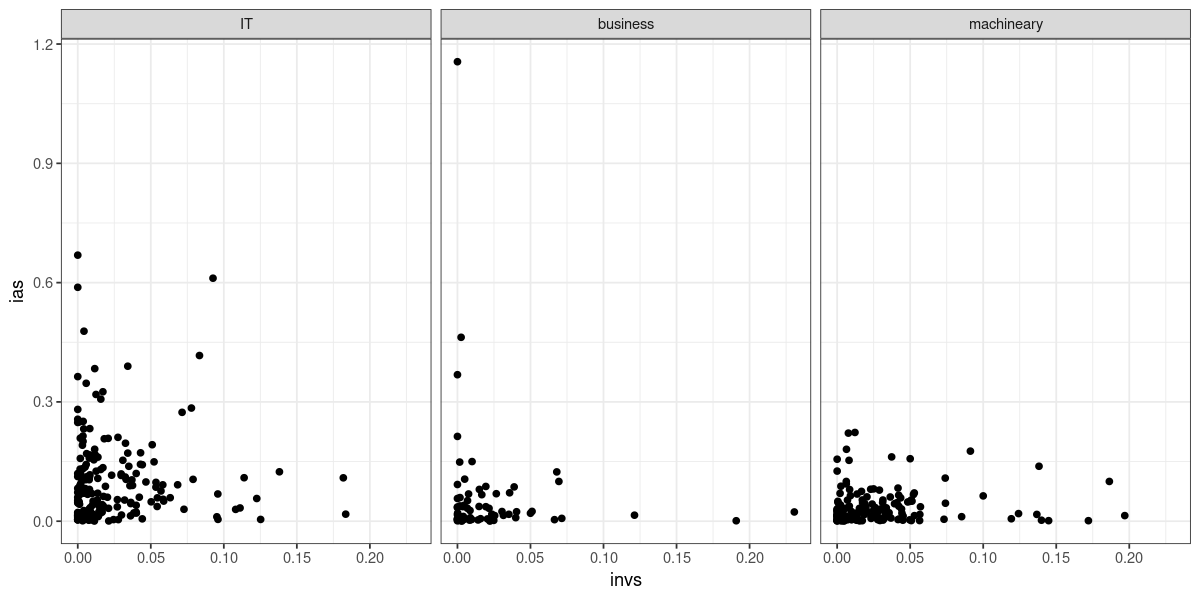

In [52]:
# plot relationship between ias and invs cross industry
options(repr.plot.width = 10, repr.plot.height = 5)
cis2 %>%
    .[ias > 0 & invs < 0.25] %>%
    .[, .(ias, invs, industry)] %>%
    ggplot(aes(x = invs, y = ias)) +
    geom_point() + 
    facet_wrap(~industry, nrow = 1) +
    theme_bw()

As you can see that the relationship between `ias` and `invs` is different for different
industries. For instance, for the industry 1, the relationship is positive. However, for
business industry the relationship is not very clear. 

Now, let's run the regression model with industry dummy variables. The regression equation
will be:

$$
ias = \beta_0 + \beta_1 invs + \beta_2 industry_1 + \beta_2 industry_2 + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

Although we have three industries, we only need two dummy variables. This is because
we need to exclude one industry as the base industry. In this case, we exclude industry 3.

In [46]:
model2 <- lm(ias ~ invs + industry, data = cis2)

# print out coefficients
stargazer(model2, type = "text")


                        Dependent variable:    
                    ---------------------------
                                ias            
-----------------------------------------------
invs                          0.084**          
                              (0.035)          
                                               
industrybusiness             -0.046***         
                              (0.008)          
                                               
industrymachineary           -0.047***         
                              (0.007)          
                                               
Constant                     0.066***          
                              (0.005)          
                                               
-----------------------------------------------
Observations                    790            
R2                             0.068           
Adjusted R2                    0.064           
Residual Std. Error      0.087 (df = 78

In [50]:
# only run regression for industry = ict
model3 <- lm(ias ~ invs, data = cis2[industry == "machineary"])

stargazer(model3, type = "text")


                        Dependent variable:    
                    ---------------------------
                                ias            
-----------------------------------------------
invs                          0.060**          
                              (0.026)          
                                               
Constant                     0.020***          
                              (0.003)          
                                               
-----------------------------------------------
Observations                    280            
R2                             0.018           
Adjusted R2                    0.015           
Residual Std. Error      0.052 (df = 278)      
F Statistic            5.175** (df = 1; 278)   
Note:               *p<0.1; **p<0.05; ***p<0.01


### Correlation does not imply causation

It is important to note that correlation does not imply causation. Even the coefficient
is significant, we cannot say that the independent variable causes the dependent variable.
For instance, here the coefficient of `markets` is significant. However, we cannot say that
firms become more innovative because they spend more on marketing. It could be the case that
firms become more innovative, so they spend more on marketing. 

Our regression model only tells us that there is a relationship between the dependent variable and the independent variable. The relationship is significant enough to reject the null hypothesis that the coefficient is zero. However, it does not tell us the direction of the relationship. It does not tell us whether the independent variable causes the dependent variable or the dependent variable causes the independent variable.

In [ ]:
# now let's use um (sales) as dependent variable
model3 <- lm(um ~ markets + softws + invs + lp + bges + ias + exs + industry, data = cis2)

# check summary of the model
summary(model3)

In [ ]:
# print out with stargazer
stargazer(model3, type = "text")